In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
tx1 = pd.read_csv('tx1.csv')
tx1.loc[:,'Date'] = pd.to_datetime(tx1['Date'])
tx1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 9 columns):
Date               2718 non-null datetime64[ns]
Open               2718 non-null float64
High               2718 non-null float64
Low                2718 non-null float64
Close              2718 non-null float64
Volume             2718 non-null float64
Change             2718 non-null float64
OpenInterest       2718 non-null int64
Days2Expiration    2718 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 191.2 KB


In [9]:
tx1.tail()

,Date,Open,High,Low,Close,Volume,Change,OpenInterest,Days2Expiration
2713,2016-12-15,9330.0,9374.0,9305.0,9368.0,126853.0,-1.0,99200,6
2714,2016-12-16,9367.0,9370.0,9309.0,9312.0,104771.0,-56.0,84931,5
2715,2016-12-19,9290.0,9317.0,9242.0,9246.0,127172.0,-65.0,51957,2
2716,2016-12-20,9261.0,9266.0,9209.0,9260.0,116914.0,16.0,32524,1
2717,2016-12-21,9261.0,9269.0,9225.0,9232.0,61153.0,-28.0,21310,0


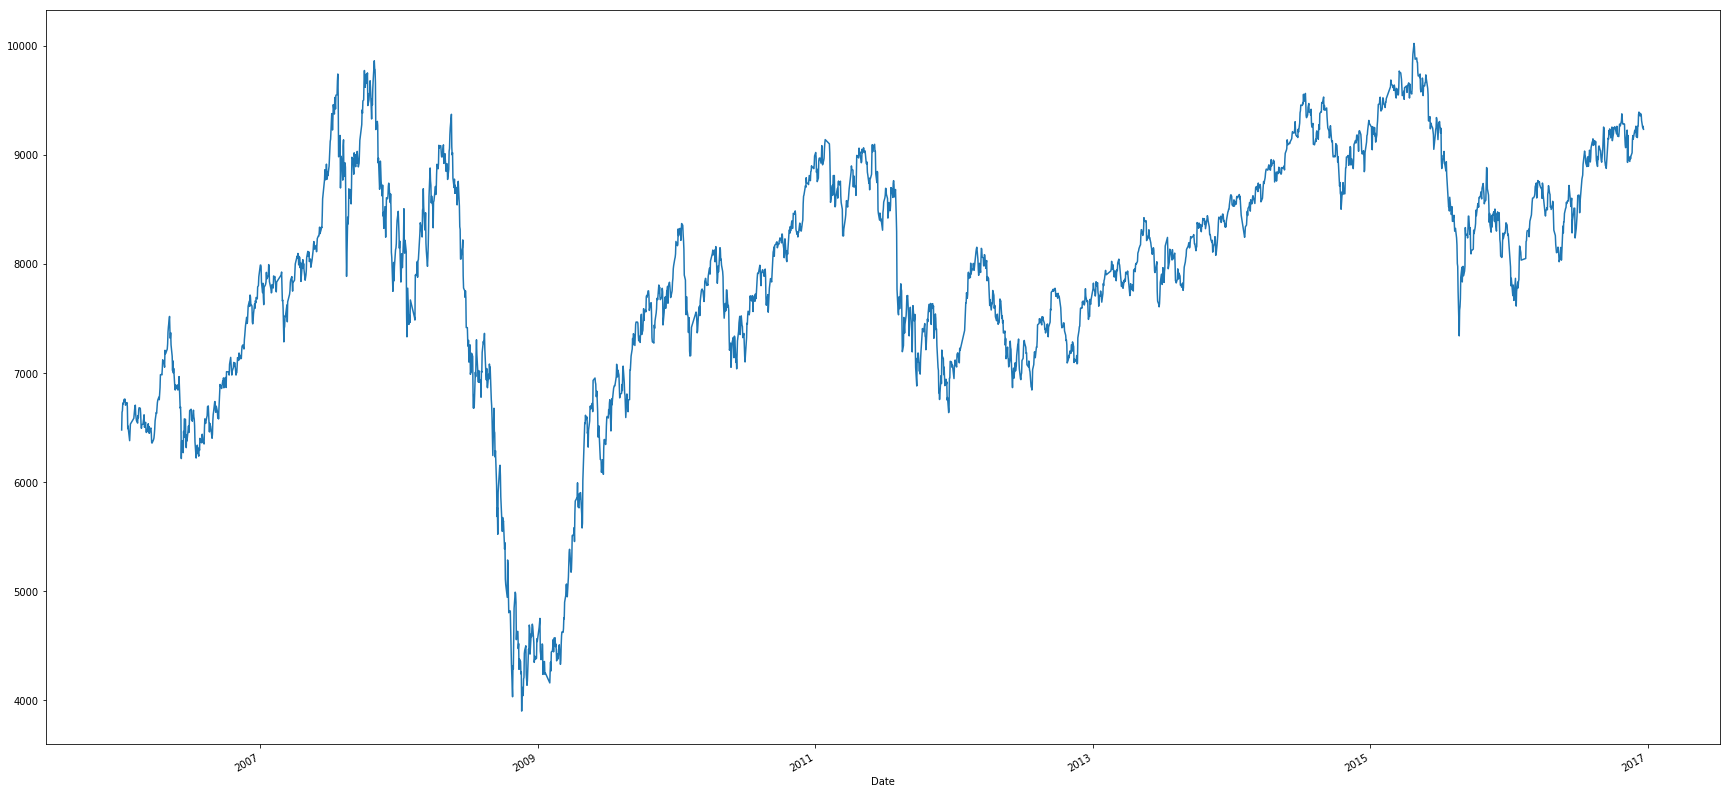

In [24]:
tx1.set_index(['Date'])['Close'].plot(kind='line', figsize=(30, 15))

## ohlc chart

In [30]:
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY

In [50]:
tx1['DateAxis'] = tx1['Date'].apply(lambda date:date2num(date))
list_of_cols = ['DateAxis', 'Open', 'High', 'Low', 'Close']
tx1_ohlc = [tuple(vals) for vals in tx1.iloc[-100:][list_of_cols].values]
tx1_ohlc;

In [51]:
mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

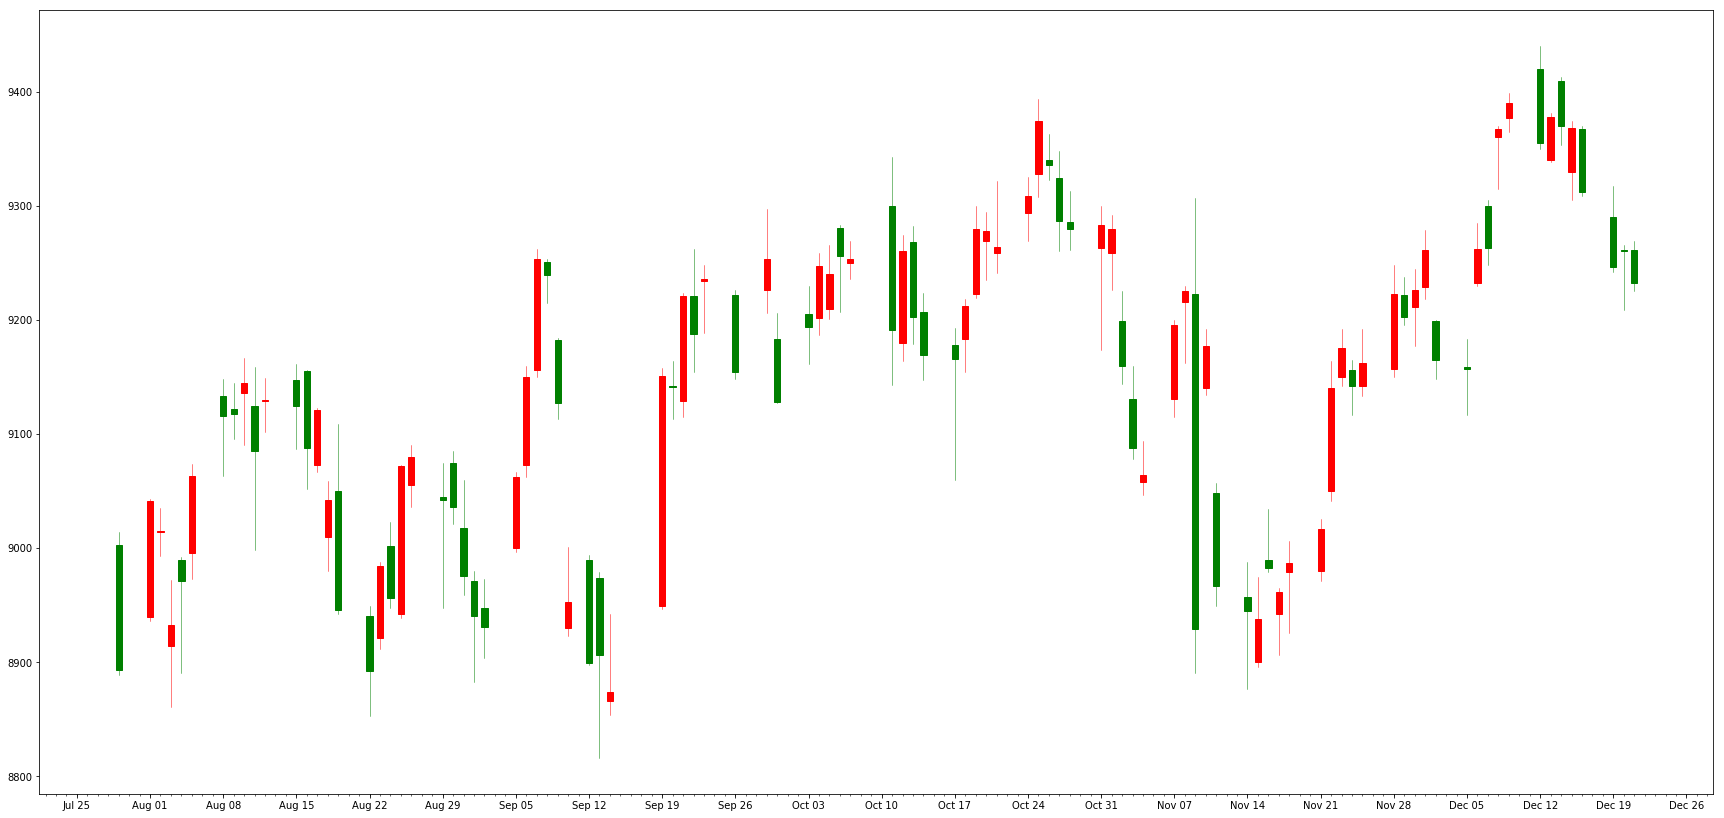

In [52]:
plt.tight_layout()
fig, ax = plt.subplots(figsize=(30,16))
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)
candlestick_ohlc(ax, tx1_ohlc, width=0.6, colorup='r', colordown='g');

### add MA5, MA20, MA60, BIAS20

In [12]:
tx1['MA5'] = tx1['Close'].rolling(5).mean()
tx1['MA20'] = tx1['Close'].rolling(20).mean()
tx1['MA60'] = tx1['Close'].rolling(60).mean()

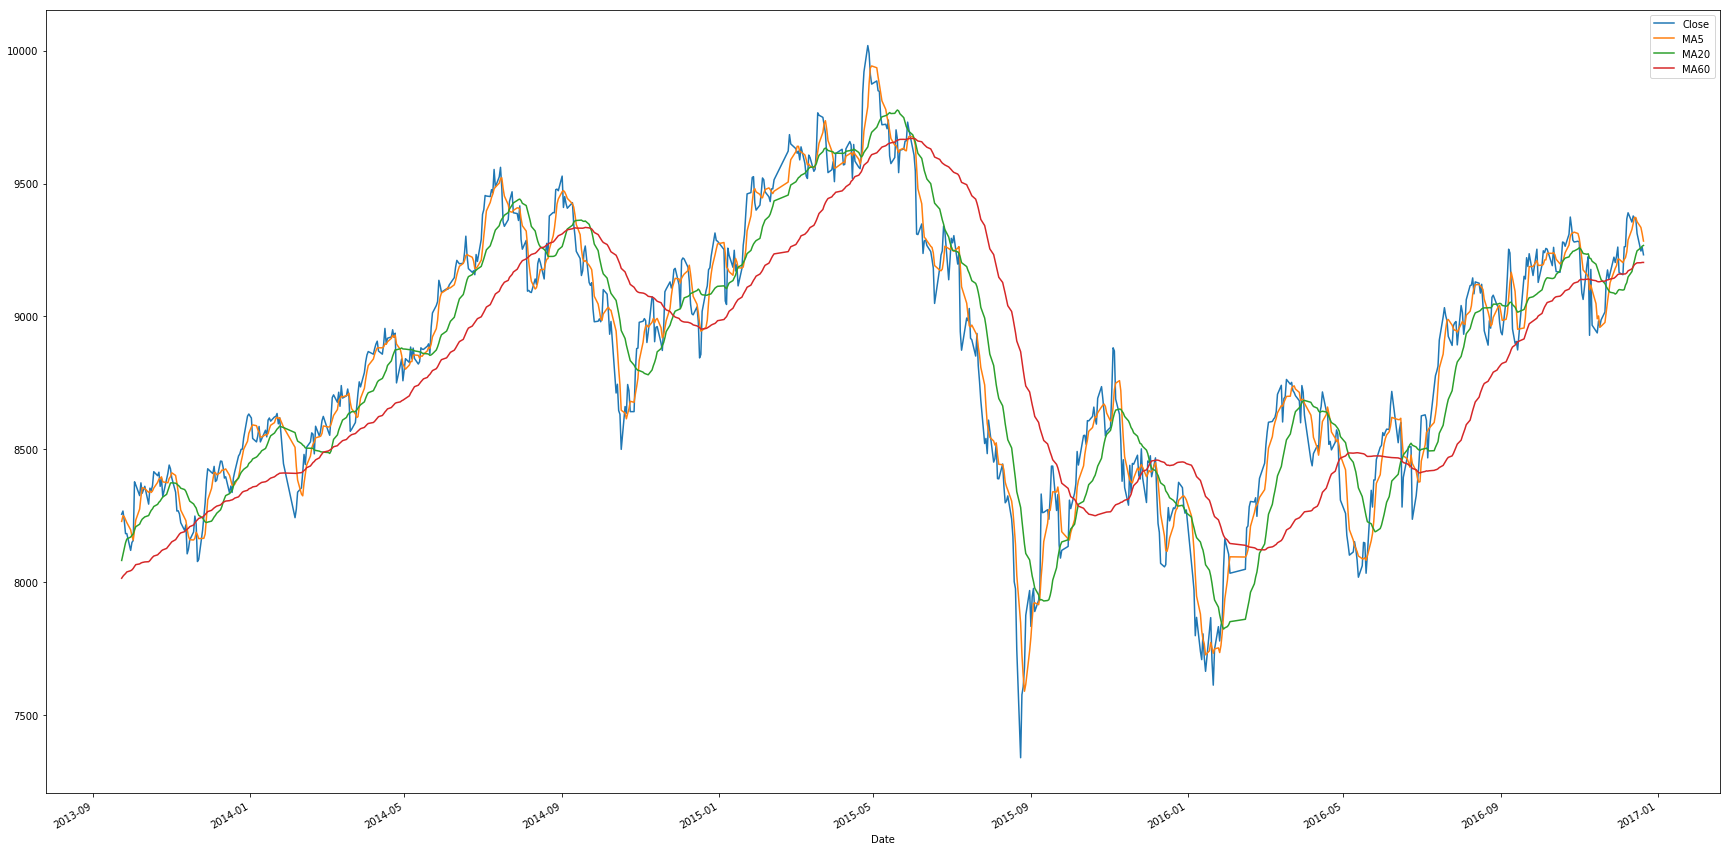

In [60]:
tx1.set_index('Date').iloc[-800:][['Close', 'MA5', 'MA20', 'MA60']].plot(figsize=(30,16))

In [79]:
tx1['BIAS20'] = (tx1['Close'] - tx1['MA20']) / tx1['MA20']

### add std dev, Bollinger Band, Bandwidth, PercentB
* https://en.wikipedia.org/wiki/Bollinger_Bands

In [63]:
tx1['Std'] = tx1['Close'].rolling(20).std()

In [65]:
tx1['BBandUpper'] = tx1['MA20'] + tx1['Std'] * 2
tx1['BBandLower'] = tx1['MA20'] - tx1['Std'] * 2

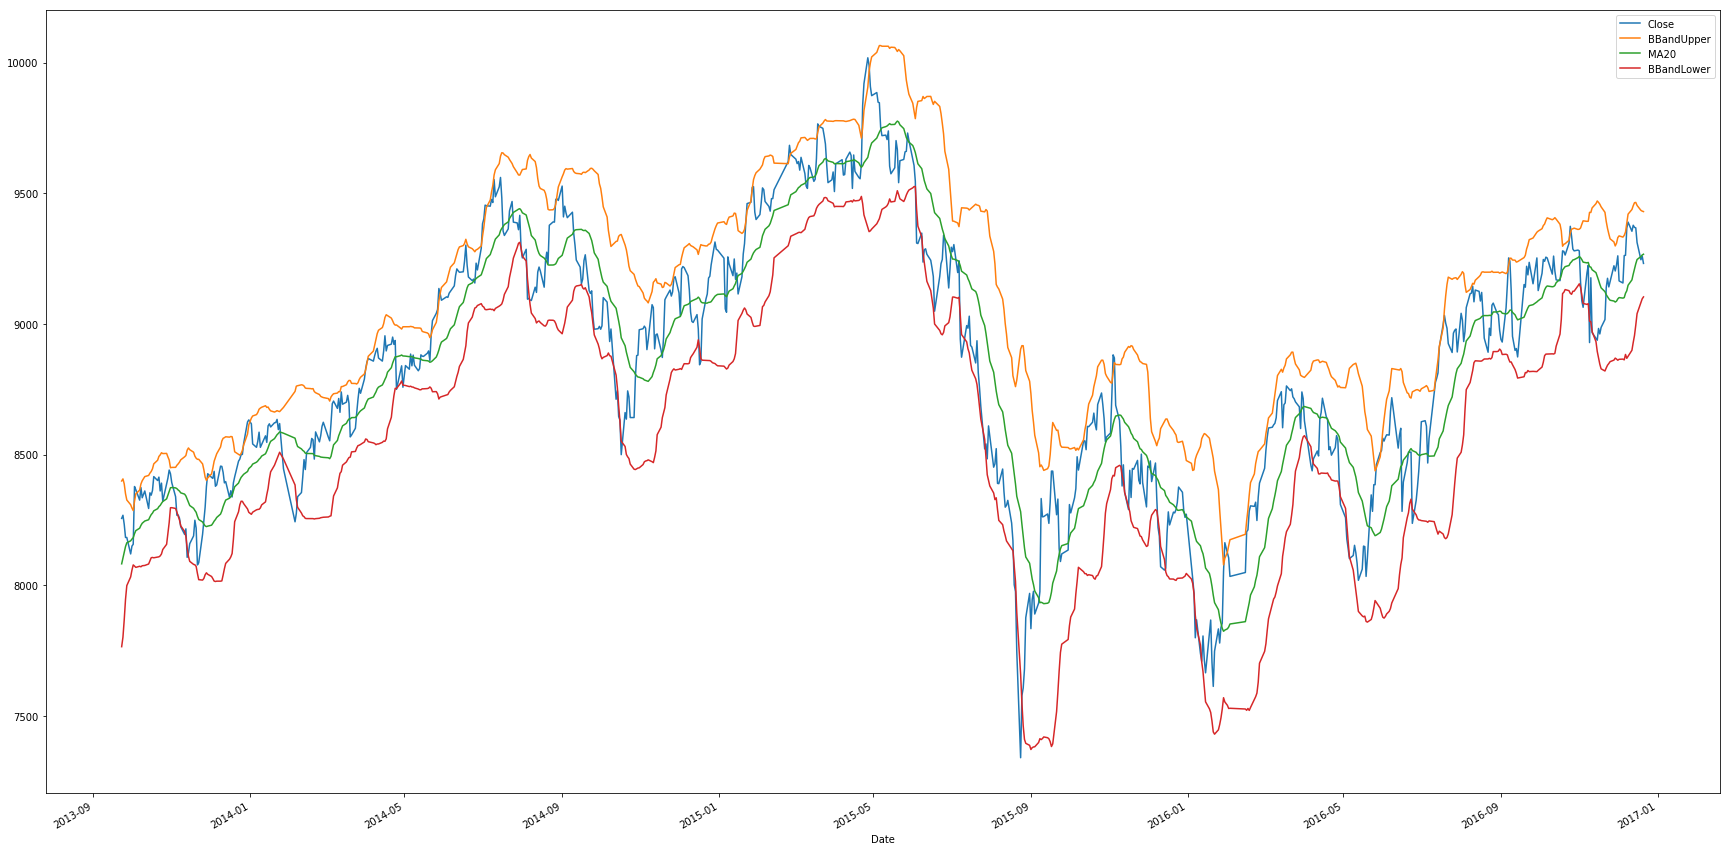

In [66]:
tx1.set_index('Date').iloc[-800:][['Close', 'BBandUpper', 'MA20', 'BBandLower']].plot(figsize=(30,16))

In [67]:
tx1['Bandwidth'] = (tx1['BBandUpper'] - tx1['BBandLower']) / tx1['MA20']

In [68]:
tx1['PercentB'] = (tx1['Close'] - tx1['BBandLower']) / (tx1['BBandUpper'] - tx1['BBandLower'])

In [73]:
import matplotlib.gridspec as gridspec

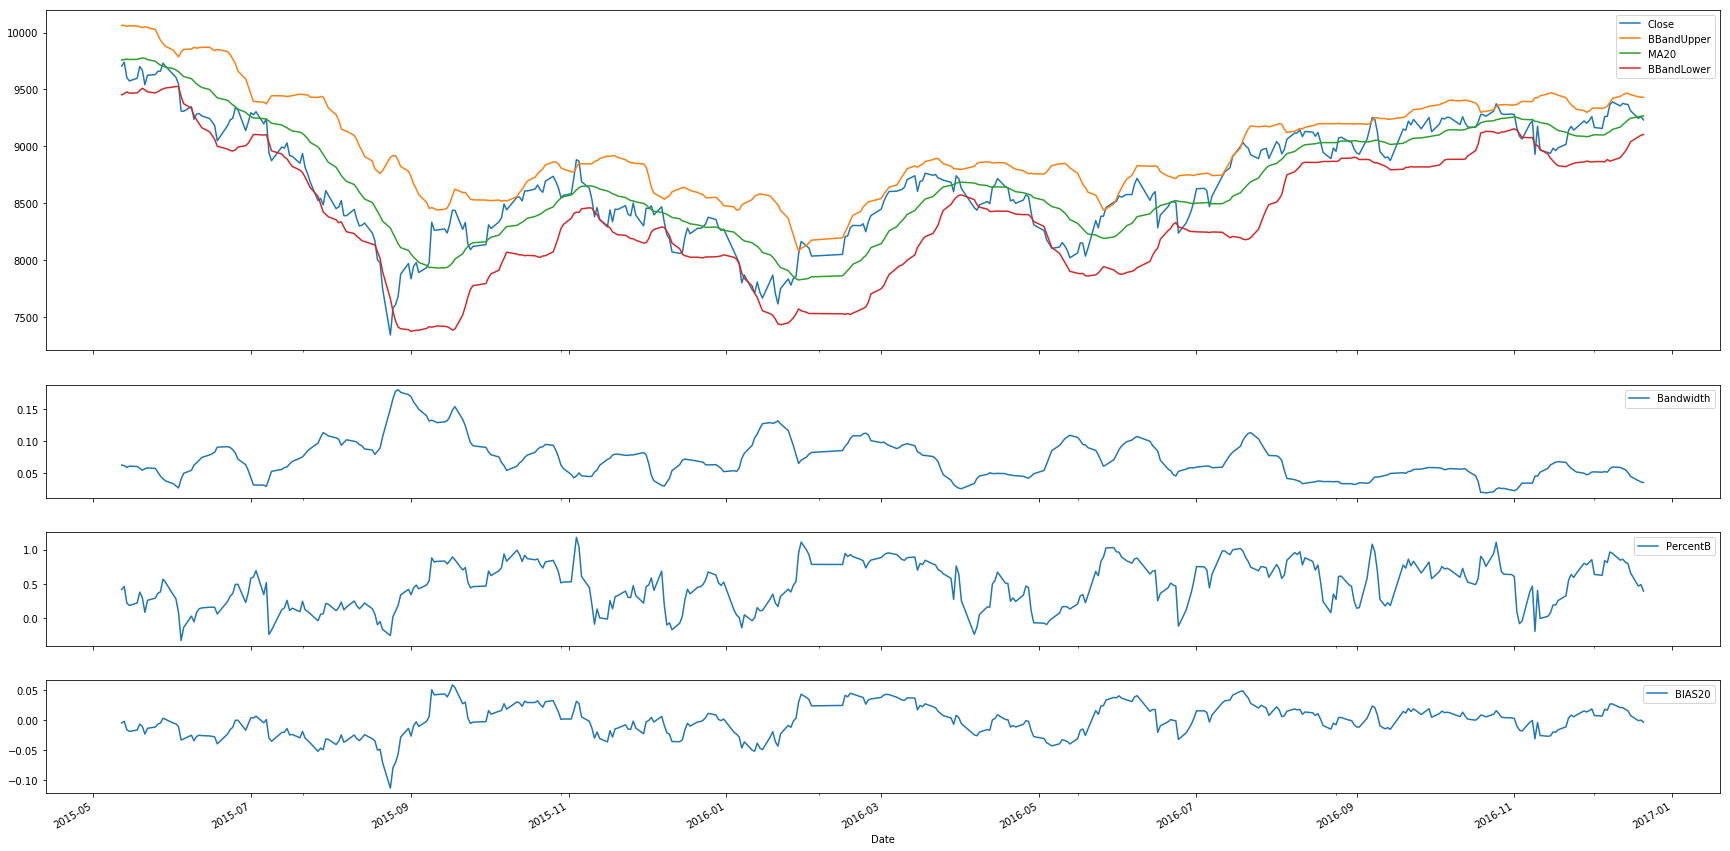

In [80]:
plt.tight_layout()
fig = plt.figure(figsize=(30, 16)) 
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1]) 

ax1 = plt.subplot(gs[0])
tx1.set_index('Date').iloc[-400:][['Close', 'BBandUpper', 'MA20', 'BBandLower']].plot(ax=ax1)
ax2 = plt.subplot(gs[1], sharex=ax1)
tx1.set_index('Date').iloc[-400:][['Bandwidth']].plot(ax=ax2)
ax3 = plt.subplot(gs[2], sharex=ax1)
tx1.set_index('Date').iloc[-400:][['PercentB']].plot(ax=ax3)
ax4 = plt.subplot(gs[3], sharex=ax1)
tx1.set_index('Date').iloc[-400:][['BIAS20']].plot(ax=ax4)

### add low20, high20

In [83]:
tx1['Low20'] = tx1['Close'].rolling(20).min()
tx1['High20'] = tx1['Close'].rolling(20).max()

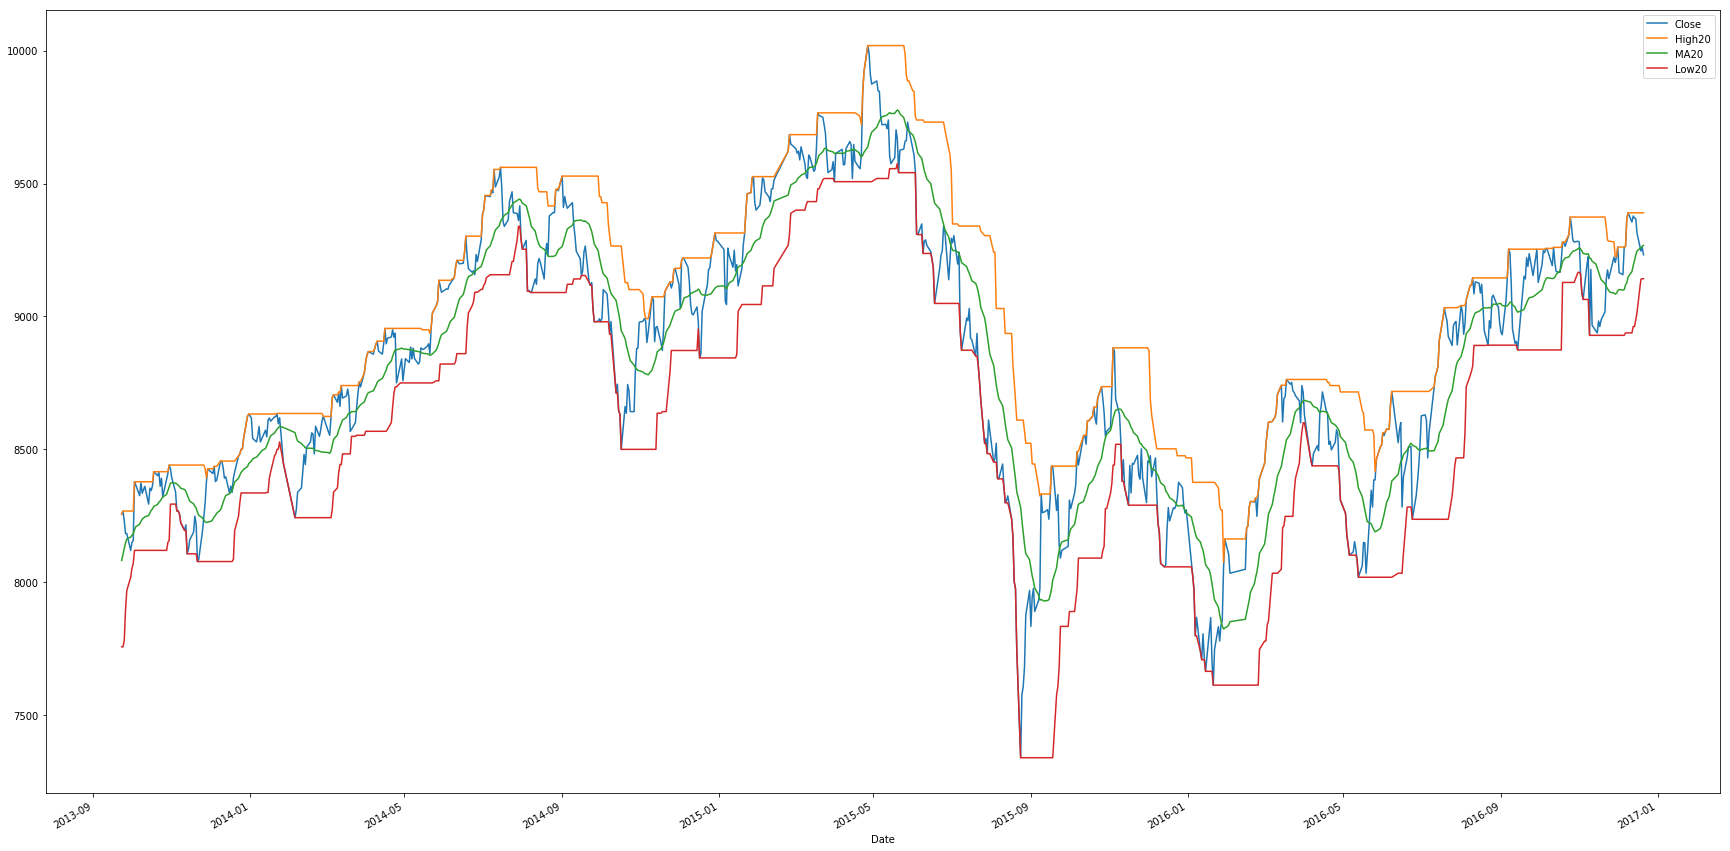

In [88]:
tx1.set_index('Date').iloc[-800:][['Close', 'High20', 'MA20', 'Low20']].plot(figsize=(30,16))

### bollinger band signal

In [123]:
import numpy as np

In [168]:
# break thru lower bound upwards
lower_than_BBandLower = (tx1['BBandLower']>tx1['Close']).astype(int)
break_thru_BBandLower_upwards = (lower_than_BBandLower.diff().shift() == -1)&(lower_than_BBandLower == 0)
tx1['break_thru_BBandLower_upwards'] = np.where(break_thru_BBandLower_upwards, 1, 0)

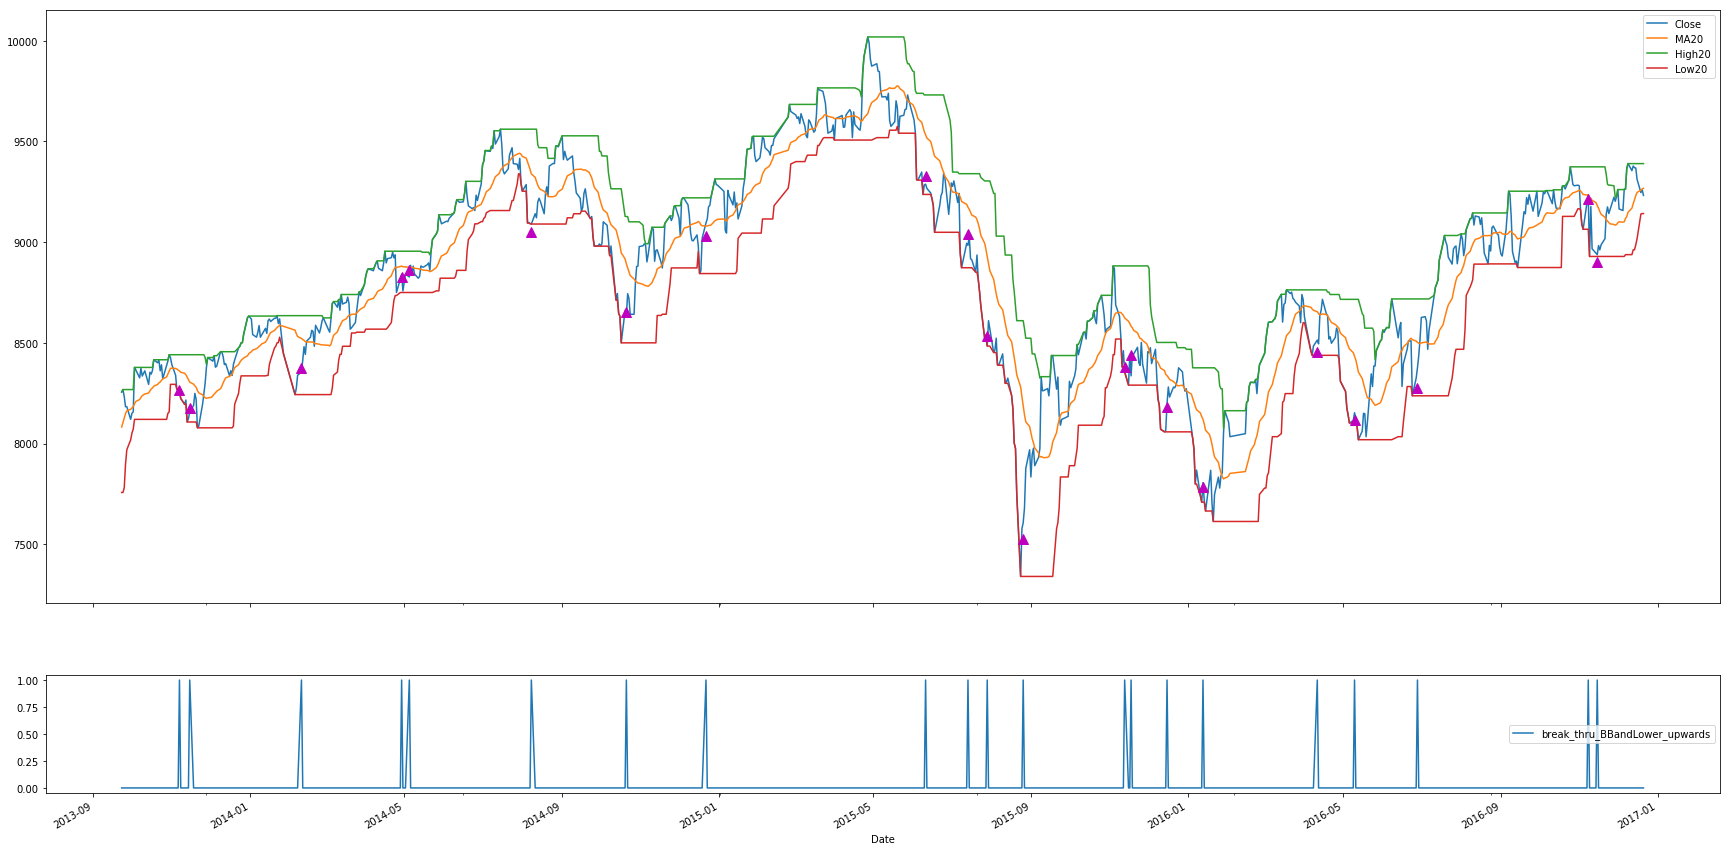

In [169]:
# buy
tx1_ = tx1[-800:].set_index('Date')
plt.tight_layout()
fig = plt.figure(figsize=(30, 16)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

ax1 = plt.subplot(gs[0])
#tx1_[['Close', 'BBandUpper', 'MA20', 'BBandLower']].plot(ax=ax1)
tx1_[['Close','MA20', 'High20', 'Low20']].plot(ax=ax1)
ax1.plot(tx1_.loc[tx1_.break_thru_BBandLower_upwards == 1.0].index, tx1_.Open[tx1_.break_thru_BBandLower_upwards == 1.0],'^', markersize=10, color='m')
ax2 = plt.subplot(gs[1], sharex=ax1)
tx1_[['break_thru_BBandLower_upwards']].plot(ax=ax2)

In [153]:
# stop loss / profit
# 1. break thru Low20 downwards
tx1['break_thru_Low20'] = tx1['Low20'].diff() # if < 0
# 2. break thru High20 upwards
tx1['break_thru_High20'] = tx1['High20'].diff() # if > 0
# 3. break thru MA20 downwards
larger_than_MA20 = (tx1['Close']>tx1['MA20']).astype(int)
break_thru_MA20_downwards = (larger_than_MA20.diff() == -1)&(larger_than_MA20 == 0)
tx1['break_thru_MA20_downwards'] = np.where(break_thru_MA20_downwards, 1, 0)

In [167]:
transactions = pd.DataFrame(columns=['orderSize', 'orderPrice', 'executedPrice', 'position'], index=tx1.index)
# tx1['break_thru_BBandLower_upwards'] == 1 -> orderSize=1
# tx1['break_thru_Low20'] == 1 -> orderType=0
# position == 1 -> orderType=0 & orderPrice=tx1['BBandUpper']
transactions['position'] = 0
transactions['orderSize'] = 0
for i in tx1.index[20:]:
    if transactions.iloc[i-1]['position'] == 0 and tx1.iloc[i]['break_thru_BBandLower_upwards'] == 1:
        transactions.iloc[i]['orderSize'] = 1
        transactions.iloc[i]['orderPrice'] = (tx1.iloc[i]['BBandUpper'] - tx1.iloc[i]['BBandLower'])/5 +tx1.iloc[i]['BBandLower']
    elif transactions.iloc[i-1]['position'] == 1 and tx1['break_thru_Low20'] < 0:
        transactions.iloc[i]['orderSize'] = -1
        transactions.iloc[i]['orderPrice'] = tx1.iloc[i]['Low20']
    elif transactions.iloc[i-1]['position'] == 1:
        transactions.iloc[i]['orderSize'] = -1
        transactions.iloc[i]['orderPrice'] = tx1.iloc[i]['BBandUpper']

    if transactions.iloc[i-1]['orderSize'] > 0 and transactions.iloc[i-1]['orderPrice']>=tx1.iloc[i]['Low']:
        transactions.iloc[i]['executedPrice'] = min(transactions.iloc[i-1]['orderPrice'], tx1.iloc[i-1]['Open'])
        transactions.iloc[i]['position'] = transactions.iloc[i-1]['position'] + transactions.iloc[i-1]['orderSize']
    elif transactions.iloc[i-1]['orderSize'] < 0 and tx1.iloc[i]['High']>=transactions.iloc[i-1]['orderPrice']:
        transactions.iloc[i]['executedPrice'] = max(transactions.iloc[i-1]['orderPrice'], tx1.iloc[i-1]['Open'])
        transactions.iloc[i]['position'] = transactions.iloc[i-1]['position'] + transactions.iloc[i-1]['orderSize']
    else:
        transactions.iloc[i]['executedPrice'] = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717


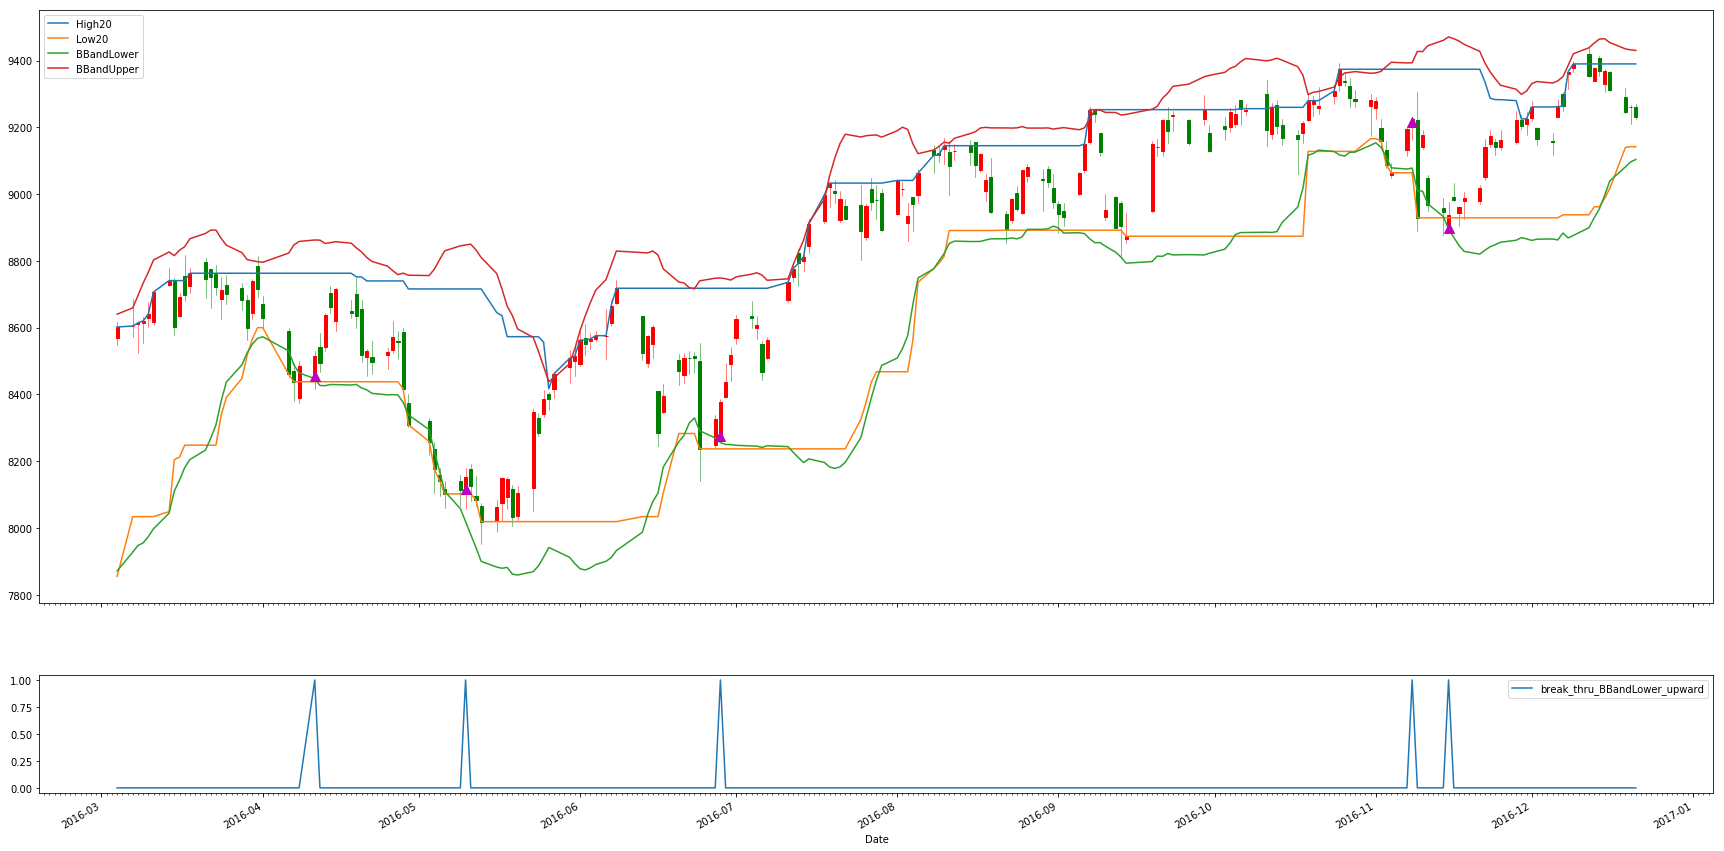

In [164]:
tx1_ = tx1[-200:].set_index('Date')
tx1_ohlc = [tuple(vals) for vals in tx1_[list_of_cols].values]
plt.tight_layout()
fig = plt.figure(figsize=(30, 16)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

ax1 = plt.subplot(gs[0])
ax1.xaxis.set_major_locator(mondays)
ax1.xaxis.set_minor_locator(alldays)
ax1.xaxis.set_major_formatter(weekFormatter)
candlestick_ohlc(ax1, tx1_ohlc, width=0.6, colorup='r', colordown='g');
#tx1_[['Close', 'BBandUpper', 'MA20', 'BBandLower']].plot(ax=ax1)
tx1_[['High20', 'Low20', 'BBandLower', 'BBandUpper']].plot(ax=ax1)
ax1.plot(tx1_.loc[tx1_.break_thru_BBandLower_upward == 1.0].index, tx1_.Open[tx1_.break_thru_BBandLower_upward == 1.0],'^', markersize=10, color='m')
#ax1.plot(tx1_.loc[tx1_.break_thru_MA20_downwards == 1.0].index, tx1_.Close[tx1_.break_thru_MA20_downwards == 1.0],'v', markersize=10, color='k')
#ax1.plot(tx1_.loc[tx1_.break_thru_Low20 < 0].index, tx1_.Close[tx1_.break_thru_Low20 < 0],'v', markersize=10, color='k')
#ax1.plot(tx1_.loc[tx1_.break_thru_High20 > 0].index, tx1_.Close[tx1_.break_thru_High20 > 0],'v', markersize=10, color='k')
ax2 = plt.subplot(gs[1], sharex=ax1)
tx1_[['break_thru_BBandLower_upward']].plot(ax=ax2)

### add break_high, break_low (label for machine learning)

### trade by break_high / break_low, and check the profilt

### predict break_high / break_low and trade, then see the result